In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from imageio import imread

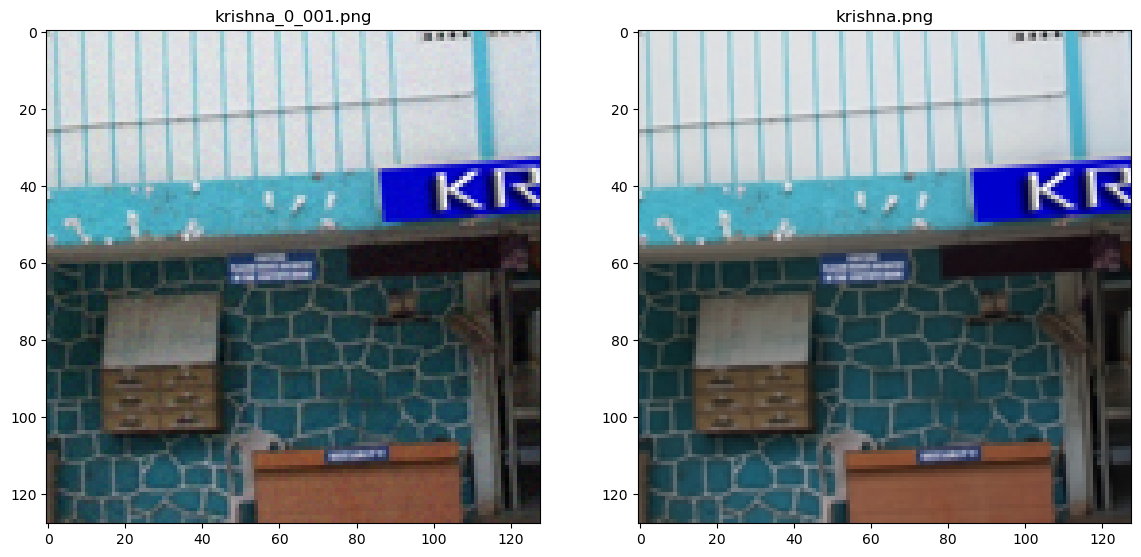

In [2]:
krishna = imread('krishna.png')/255
krishna_noisy = imread('krishna_0_001.png')/255
plt.figure(figsize=[14,8])
plt.subplot(121)
plt.imshow(krishna_noisy)
plt.title("krishna_0_001.png")
plt.subplot(122)
plt.imshow(krishna)
plt.title("krishna.png");

In [34]:
krishna.dtype

dtype('float64')

In [3]:
def zero_pad_image(image, pad_size):
    x, y = np.shape(image)
    padded_image = np.zeros((x+2*pad_size, y+2*pad_size))
    padded_image[pad_size:-pad_size, pad_size:-pad_size] = image
    return padded_image

In [4]:
def zero_pad_image_RGB(image, w, w_sim):
    x, y, _ = np.shape(image)
    pad_size = w+w_sim
    padded_image = np.zeros((x+2*pad_size, y+2*pad_size, 3))
    for i in range(3):
        padded_image[pad_size:-pad_size,
                     pad_size:-pad_size, i] = image[:, :, i]
    return padded_image

# PSNR
$$
PSNR = 10log_{10}\left(\frac{1}{MSE}\right)
$$

In [30]:
def PSNR(latent_image, noisy_image):
    mse = np.mean((noisy_image-latent_image)**2)
    if mse > 0:
        return 10*np.log10(1/mse)
    else:
        return np.float128('2e315')

# NLM Local

$$
w(p) = \frac{1}{Z}\Sigma_{q\in W_{sim}}G_{\sigma}(\mathcal{N}_{p}-\mathcal{N}_{q})f(q)
$$


$$
Z = \Sigma_{p\in W}w(p)
$$


In [6]:
def intensity_gaussian(p, q, sigma):
    if sigma > 0:
        return np.exp(np.sum((-1*(p-q)**2)/(2*sigma**2)))
    else:
        if np.sum(np.abs(p-q)) == 0:
            return 1
        else:
            return 0

In [7]:
def NLM_local(impatch, surroundings, d, W_sim, sigma, return_kernel=False):
    
    weights = np.zeros((2*d+1 - 2*W_sim, 2*d+1 - 2*W_sim))
    filtered_val = 0
    for i in range(W_sim, 2*d+1 - W_sim):
        for j in range(W_sim, 2*d+1 - W_sim):
            
            q = surroundings[i-W_sim:i+W_sim+1, j-W_sim:j+W_sim+1]
            
            weights[i-W_sim, j-W_sim] = intensity_gaussian(impatch, q, sigma)
            
            filtered_val += weights[i-W_sim, j-W_sim]*surroundings[i, j]
    if return_kernel:
        return filtered_val/np.sum(weights), weights/np.sum(weights)
    else:
        return filtered_val/np.sum(weights)

In [8]:
def NLM(image, W, W_sim, sigma):
    # get the image shape
    x, y, _ = np.shape(image)
    # zero pad the image
    padded_image = zero_pad_image_RGB(image, W, W_sim)
    d = W + W_sim
    filtered_image = np.zeros((x, y, 3))
    # for each channel
    for channel in range(3):
        padded_image_channel = padded_image[:, :, channel]
        for i in range(d, x+d):
            for j in range(d, y+d):
                # get the patch around a pixel of shape (2*W_sim+1, 2*W_sim+1)
                impatch = padded_image_channel[i -
                                               W_sim:i+W_sim+1, j-W_sim:j+W_sim+1]
                # get its surroundings of shape (2*W+1, 2*W+1)
                surroundings = padded_image_channel[i-d:i+d+1, j-d:j+d+1]
                # get the filtered value
                filtered_image[i-d, j-d, channel] = NLM_local(
                    impatch, surroundings, d, W_sim, sigma)
    return filtered_image

# NLM Filtering

In [9]:
sigma_vals = [0.1, 0.2, 0.3, 0.4, 0.5]
W_sim = 3
W_vals = [3, 5]
gaussian_kernel_size = 7
rows = (31, 38)
columns = (46, 58)
NLM_data = {}
Gaussian_data = {}
for sigma in sigma_vals:
    for W in W_vals:
        print(
            f"Performing NLM filtering for sigma={sigma}, W={W}, W_sim={W_sim}")
        NLM_filtered_image = NLM(krishna_noisy, W, W_sim, sigma)
        NLM_data[(sigma, W)] = (NLM_filtered_image,
                                PSNR(krishna, NLM_filtered_image))

Performing NLM filtering for sigma=0.1, W=3, W_sim=3
Performing NLM filtering for sigma=0.1, W=5, W_sim=3
Performing NLM filtering for sigma=0.2, W=3, W_sim=3
Performing NLM filtering for sigma=0.2, W=5, W_sim=3
Performing NLM filtering for sigma=0.3, W=3, W_sim=3
Performing NLM filtering for sigma=0.3, W=5, W_sim=3
Performing NLM filtering for sigma=0.4, W=3, W_sim=3
Performing NLM filtering for sigma=0.4, W=5, W_sim=3
Performing NLM filtering for sigma=0.5, W=3, W_sim=3
Performing NLM filtering for sigma=0.5, W=5, W_sim=3


# W = 3

Text(0.5, 1.0, '$\\sigma$ = 0.5')

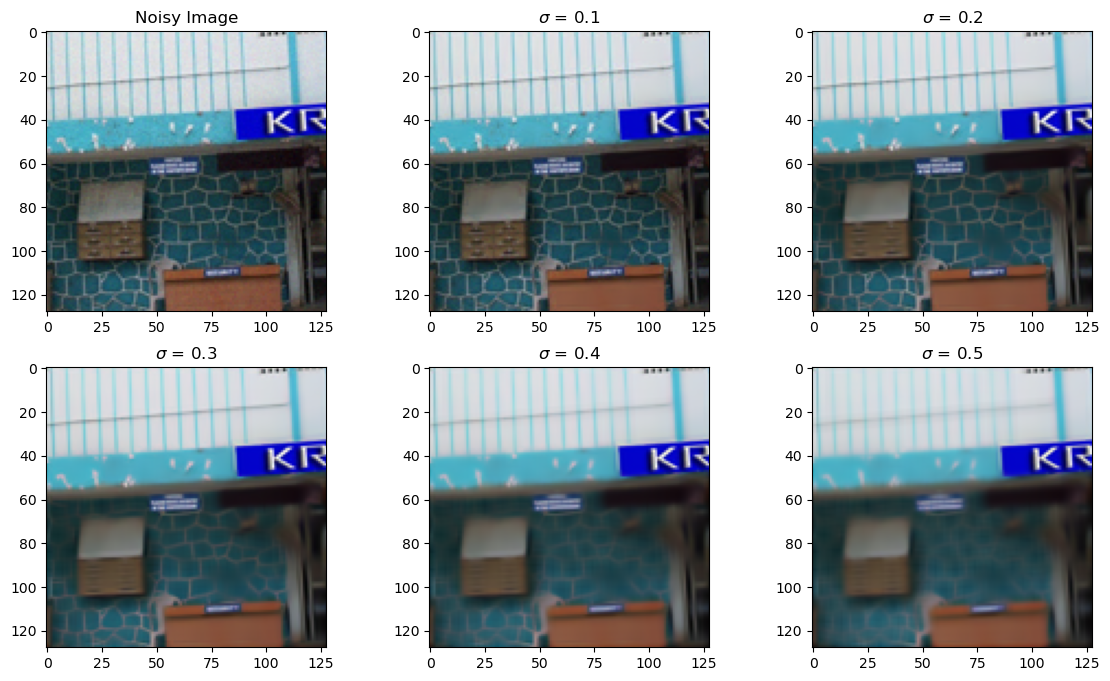

In [10]:
plt.figure(figsize=[14,8])
plt.subplot(231)
plt.imshow(krishna_noisy)
plt.title("Noisy Image")
plt.subplot(232)
plt.imshow(NLM_data[(sigma_vals[0], W_vals[0])][0])
plt.title("$\sigma$ = {}".format(sigma_vals[0]))
plt.subplot(233)
plt.imshow(NLM_data[(sigma_vals[1], W_vals[0])][0])
plt.title("$\sigma$ = {}".format(sigma_vals[1]))
plt.subplot(234)
plt.imshow(NLM_data[(sigma_vals[2], W_vals[0])][0])
plt.title("$\sigma$ = {}".format(sigma_vals[2]))
plt.subplot(235)
plt.imshow(NLM_data[(sigma_vals[3], W_vals[0])][0])
plt.title("$\sigma$ = {}".format(sigma_vals[3]))
plt.subplot(236)
plt.imshow(NLM_data[(sigma_vals[4], W_vals[0])][0])
plt.title("$\sigma$ = {}".format(sigma_vals[4]))

# W = 5

Text(0.5, 1.0, '$\\sigma$ = 0.5')

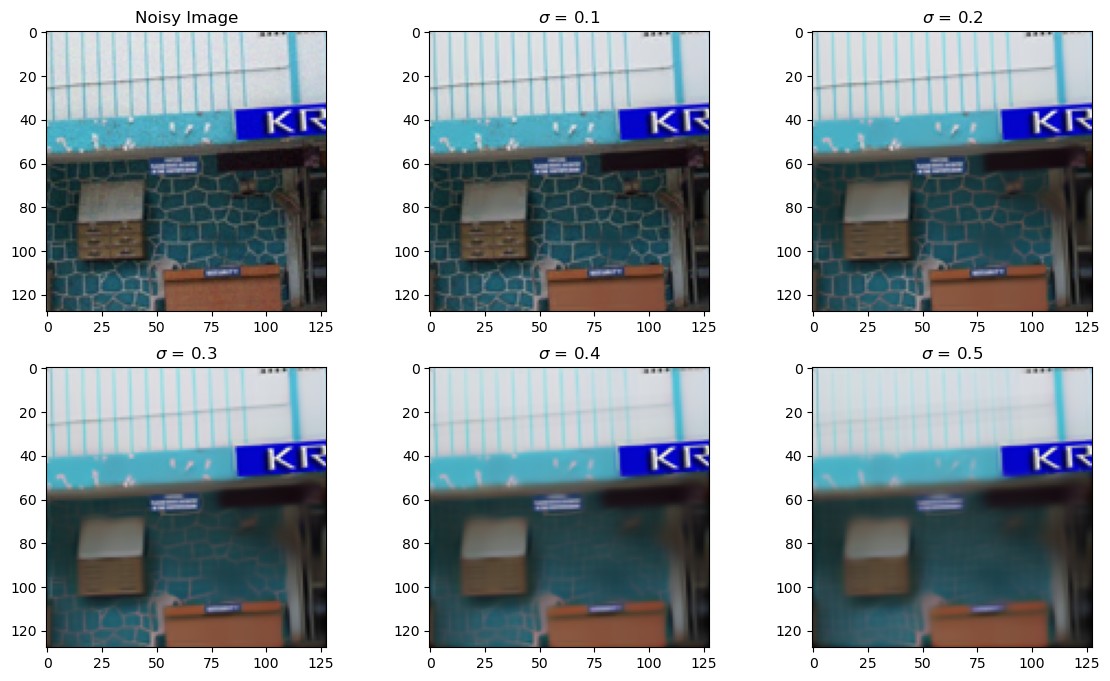

In [12]:
plt.figure(figsize=[14,8])
plt.subplot(231)
plt.imshow(krishna_noisy)
plt.title("Noisy Image")
plt.subplot(232)
plt.imshow(NLM_data[(sigma_vals[0], W_vals[1])][0])
plt.title("$\sigma$ = {}".format(sigma_vals[0]))
plt.subplot(233)
plt.imshow(NLM_data[(sigma_vals[1], W_vals[1])][0])
plt.title("$\sigma$ = {}".format(sigma_vals[1]))
plt.subplot(234)
plt.imshow(NLM_data[(sigma_vals[2], W_vals[1])][0])
plt.title("$\sigma$ = {}".format(sigma_vals[2]))
plt.subplot(235)
plt.imshow(NLM_data[(sigma_vals[3], W_vals[1])][0])
plt.title("$\sigma$ = {}".format(sigma_vals[3]))
plt.subplot(236)
plt.imshow(NLM_data[(sigma_vals[4], W_vals[1])][0])
plt.title("$\sigma$ = {}".format(sigma_vals[4]))

# Gaussian

In [13]:
def gaussian_kernel(sigma, w):
    d = w//2
    # blur kernel of the required size
    blur_kernel = np.zeros((w, w))
    if w == 1:
        # to prevent division by zero errors when the sigma value is zero
        # when sigma is zero, the Gaussian kernel is essentially [[1]]
        return np.ones((w, w))
    for i in range(w):
        for j in range(w):
            # As defined in class
            # skipping the 1/(2*np.pi*sigma**2) constant as it will cancel
            # out anyways in the sum and calculating it again and again is
            # just useless computation
            blur_kernel[i, j] = np.exp((-(i-d)**2-(j-d)**2)/(2*(sigma**2)))
    # divide by the sum of the entries so that the entries of the kernel
    # sum up to 1. This is necessary to ensure that we do not dim or brighten
    # the image we are convolving
    blur_kernel = blur_kernel/np.sum(blur_kernel)
    return blur_kernel

In [14]:
def conv_2D(image, kernel, conv_type='same', correlation=True):
    # get the shape of the image
    x, y = np.shape(image)
    # get the shape of the kernel
    # assumed that the kernel is a square matrix
    w = len(kernel)
    d = w//2
    # if the kernel is a single value, simply multiply and return
    if d == 0:
        filtered_image = kernel*image
    else:
        if not correlation:
            # flip the kernel if convolution is to be performed
            kernel = kernel[::-1, ::-1]
        if conv_type == 'valid':
            # no zero padding needed now
            filtered_image = np.zeros((x-2*d, y-2*d))
            for i in range(d, x-d):
                for j in range(d, y-d):
                    # extract image patch
                    patch = image[i-d:i+d+1, j-d:j+d+1]
                    # multiply image patch with the kernel, sum and store
                    filtered_image[i-d, j-d] = np.sum(patch*kernel)
        elif conv_type == 'same':
            # zero pad so that the output is of the same size
            padded_image = zero_pad_image(image, d)
            filtered_image = np.zeros((x, y))
            for i in range(d, x+d):
                for j in range(d, x+d):
                    # extract image patch
                    patch = padded_image[i-d:i+d+1, j-d:j+d+1]
                    # multiply image patch with the kernel, sum and store
                    filtered_image[i-d, j-d] = np.sum(patch*kernel)
        else:
            filtered_image = image
    return filtered_image

In [15]:
def gaussian_denoising_RGB(image, sigma, w):
    x, y, _ = np.shape(image)
    kernel = gaussian_kernel(sigma, w)
    filtered_image = np.zeros((x, y, 3))
    for channel in range(3):
        filtered_image[:, :, channel] = conv_2D(image[:, :, channel], kernel)
    return filtered_image

# Gaussian Filtering

In [16]:
for sigma in sigma_vals:
    print(f"Performing Gaussian filtering for sigma={sigma}")
    gaussian_filtered_image = gaussian_denoising_RGB(
        krishna_noisy, sigma, gaussian_kernel_size)
    Gaussian_data[sigma] = (gaussian_filtered_image,
                            PSNR(krishna, gaussian_filtered_image))

Performing Gaussian filtering for sigma=0.1
Performing Gaussian filtering for sigma=0.2
Performing Gaussian filtering for sigma=0.3
Performing Gaussian filtering for sigma=0.4
Performing Gaussian filtering for sigma=0.5


Text(0.5, 1.0, '$\\sigma$ = 0.5')

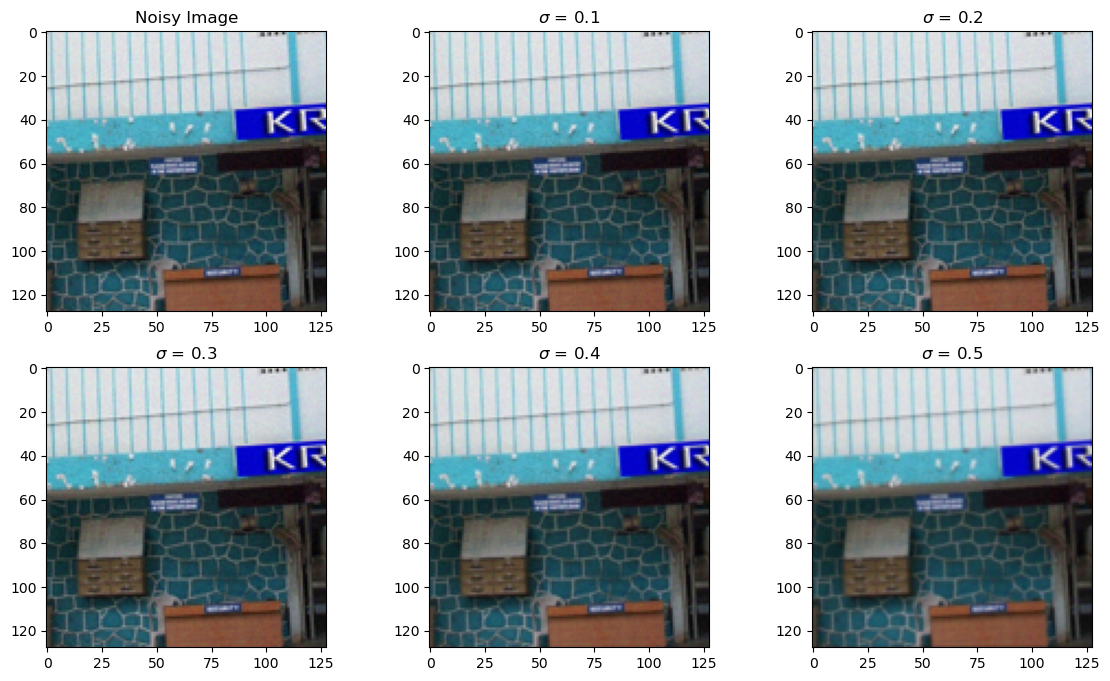

In [17]:
plt.figure(figsize=[14,8])
plt.subplot(231)
plt.imshow(krishna_noisy)
plt.title("Noisy Image")
plt.subplot(232)
plt.imshow(Gaussian_data[sigma_vals[0]][0])
plt.title("$\sigma$ = {}".format(sigma_vals[0]))
plt.subplot(233)
plt.imshow(Gaussian_data[sigma_vals[1]][0])
plt.title("$\sigma$ = {}".format(sigma_vals[1]))
plt.subplot(234)
plt.imshow(Gaussian_data[sigma_vals[2]][0])
plt.title("$\sigma$ = {}".format(sigma_vals[2]))
plt.subplot(235)
plt.imshow(Gaussian_data[sigma_vals[3]][0])
plt.title("$\sigma$ = {}".format(sigma_vals[3]))
plt.subplot(236)
plt.imshow(Gaussian_data[sigma_vals[4]][0])
plt.title("$\sigma$ = {}".format(sigma_vals[4]))

# PSNR

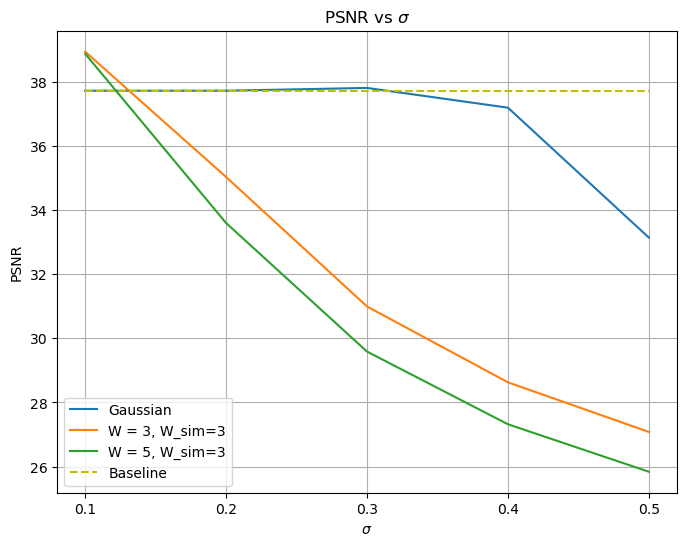

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(sigma_vals, [PSNR(krishna, Gaussian_data[sigma][0]) for sigma in sigma_vals])
plt.plot(sigma_vals, [PSNR(krishna, NLM_data[(sigma, W_vals[0])][0]) for sigma in sigma_vals])
plt.plot(sigma_vals, [PSNR(krishna, NLM_data[(sigma, W_vals[1])][0]) for sigma in sigma_vals])
plt.plot(sigma_vals, [PSNR(krishna, krishna_noisy)
                      for sigma in sigma_vals], 'y--')
plt.xlabel(r"${\sigma}$")
plt.ylabel("PSNR")
plt.grid(True)
plt.legend(["Gaussian", "W = 3, W_sim=3", "W = 5, W_sim=3", "Baseline"])
plt.xticks(sigma_vals)
plt.title(r"PSNR vs $\sigma$")
plt.show()

In [19]:
def visualize(image, row1, column1, row2, column2, W=None, W_sim=None, sigma=None, is_kernel=False):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
        2, 2, figsize=(7, 7), constrained_layout=True)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4.set_xticks([])
    ax4.set_yticks([])
    if not is_kernel:
        if W is not None:
            ax1.imshow(image[row1-W-1:row1+W, column1-W-1:column1+W])
            ax2.imshow(image[row1-W-1:row1+W, column2-W-1:column2+W])
            ax3.imshow(image[row2-W-1:row2+W, column1-W-1:column1+W])
            ax4.imshow(image[row2-W-1:row2+W, column2-W-1:column2+W])
            ax1.title.set_text(f"row : {row1}, column : {column1}")
            ax2.title.set_text(f"row : {row1}, column : {column2}")
            ax3.title.set_text(f"row : {row2}, column : {column1}")
            ax4.title.set_text(f"row : {row2}, column : {column2}")
            ax1.axis('off')
            ax2.axis('off')
            ax3.axis('off')
            ax4.axis('off')
            plt.show()
        else:
            print("Invalid Inputs")
    else:
        if (W is not None) and (W_sim is not None) and (sigma is not None):
            padded_image = zero_pad_image_RGB(image, W, W_sim)
            d = W+W_sim
            k1 = np.zeros((2*W+1, 2*W+1, 3))
            k2 = np.zeros((2*W+1, 2*W+1, 3))
            k3 = np.zeros((2*W+1, 2*W+1, 3))
            k4 = np.zeros((2*W+1, 2*W+1, 3))
            for channel in range(3):
                _, k1[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k2[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k3[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)
                _, k4[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
            # Boost up the kernels before displaying for better visualization
            ax1.imshow(k1*1/np.max(k1))
            ax2.imshow(k2*1/np.max(k2))
            ax3.imshow(k3*1/np.max(k3))
            ax4.imshow(k4*1/np.max(k4))
            ax1.title.set_text(f"row : {row1}, column : {column1}")
            ax2.title.set_text(f"row : {row1}, column : {column2}")
            ax3.title.set_text(f"row : {row2}, column : {column1}")
            ax4.title.set_text(f"row : {row2}, column : {column2}")
            ax1.axis('off')
            ax2.axis('off')
            ax3.axis('off')
            ax4.axis('off')
            plt.show()
        else:
            print("Invalid Inputs")

# Gaussian Kernel

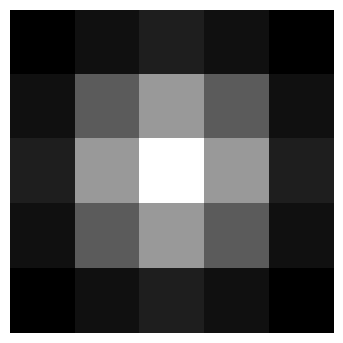

In [20]:
plt.figure(figsize=(4.2, 4.2))
plt.imshow(gaussian_kernel(sigma=1, w=5), 'gray')
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

# Noisy Image Patches

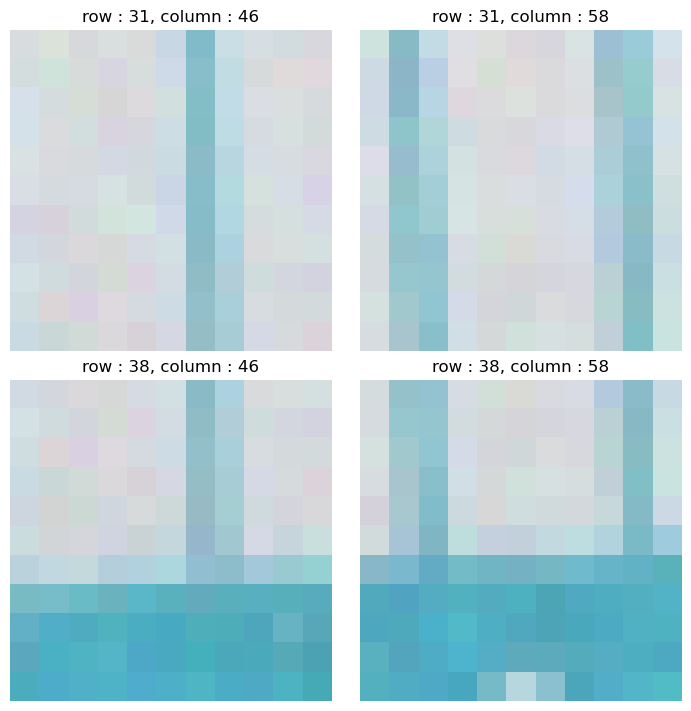

In [23]:
visualize(krishna_noisy, rows[0], columns[0],
          rows[1], columns[1], W=5, is_kernel=False)

# NLM Weights Kernels

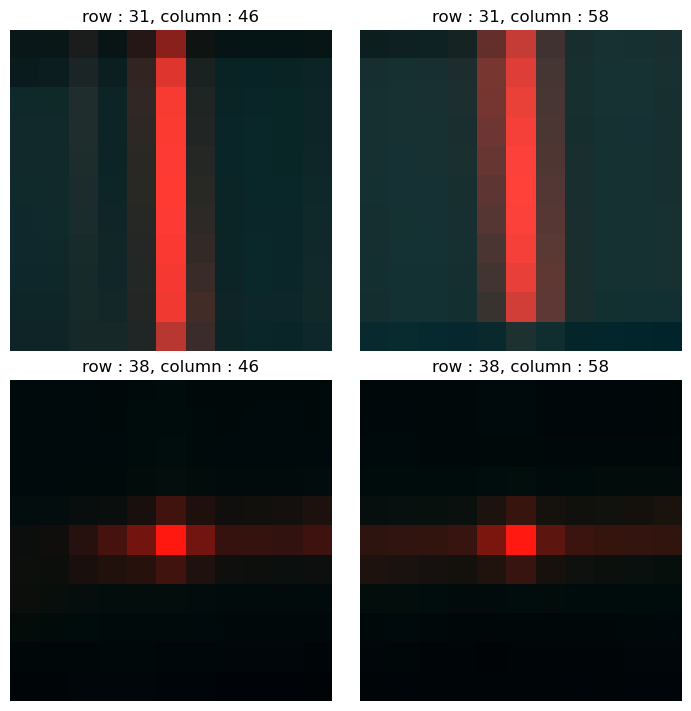

In [ ]:
visualize(krishna, rows[0], columns[0], rows[1],
          columns[1], W=5, W_sim=3, sigma=0.5, is_kernel=True)

# NLM Filtered patch

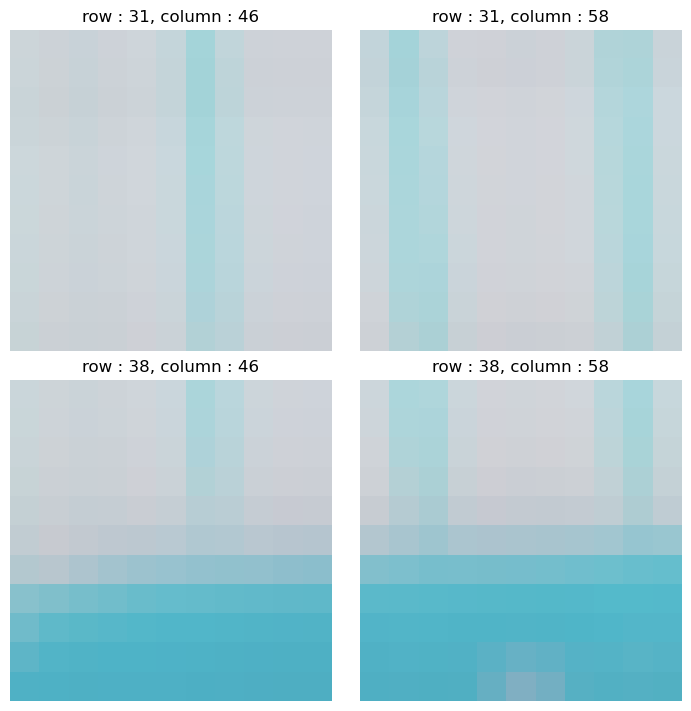

In [25]:
visualize(NLM_data[(0.5, 5)][0], rows[0], columns[0],
          rows[1], columns[1], W=5, is_kernel=False)

# Gaussian Filtered patch

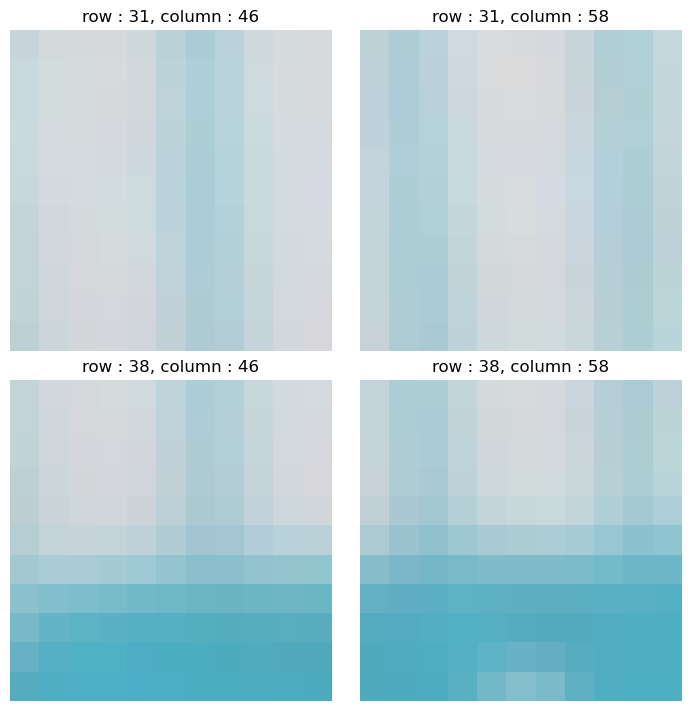

In [26]:
visualize(gaussian_denoising_RGB(krishna_noisy, sigma=1, w=5),
          rows[0], columns[0], rows[1], columns[1], W=5, is_kernel=False)